# Machine learning demonstration - x



To run this notebook, you need to install python dependencies:

Install tensorflow:

With conda:

``conda install -c conda-forge tensorflow``

With pip:

```pip install tensorflow==1.12.0```

>  If you have a GPU in your computer, you can install the gpu version to speed up some computations by following the instructions in this link: https://www.tensorflow.org/install/

Other dependencies:

With pip:

```pip install pydl==0.6.0
pip install scipy==0.19.1
pip install -U scikit-learn==0.19.1
pip install matplotlib==2.1.0
pip install numpy==1.14.5
pip install seaborn==0.8
pip install --user --upgrade tensorflow-probability```


# TCES classification


The Transiting Exoplanet Survey Satellite (TESS) was launched by NASA in April 2018 and will be in orbit for two years with the main objective of discovering thousands of new exoplanets in orbit around the brightest stars of the solar neighborhood. Its aim is to capture drops in brightness around the target stars that may indicate the presence of a transiting planet. However, drops in brightness are not always caused by transiting planets but they are originated by eclipsing binaries, background eclipsing binaries or simple noise.

In order to differentiate drops in brightness caused by actual transiting planets, a light curve for each star is extracted from the data captured by TESS. These light curves are the result of a highly complex pipeline developed by NASA that involves several processes to remove noise and trends introduced by the satellite itself when generating the data. This pipeline also includes a final stage that computes several measurements and applies statistical tests to filter stars that could host a transiting planet. Only stars that pass the tests are given to a data validation stage that processes again the light curves of these stars to detect Threshold-Crossing-Events (TCE).

TCEs are planet candidates defined by different features such as period, epoch and duration found in this data validation process. However, many false positives (noise, eclipsing binaries and background eclipsing binaries) are also detected and characterized due to presence of features similar to planets, which might be an issue since studying stars implies many expensive resources (in both time and money). Therefore, it is crucial to reduce the number of false positives in some way.

The objective of this notebook is to build a bayesian neural network able to classify these TCEs detected by the pipeline as either false positives or real planets. Period, epoch and duration defining each TCE will be used to generate a local view of the light curves, which emphasizes drops in brightness of the stars where the planet candidates were found. Finally, a bayesian neural network will be trained on the local views to determine if they were originated by real transiting planets or another phenomenon.

## Data

Data of 15000 different simulated stars was generated by NASA. Planets (one or more) were injected in some stars following well known planet models while eclipsing binaries and background eclipsing binaries were injected in some other stars by also using well known models that simulate these phenomena. There are also stars where only noise was added. Therefore, this simulated data provides a catalogue of exoplanets for which we know all the features and allows us to determine if TCEs represent actual planets or false positives.

Generated data was given to the pipeline to extract the 15000 light curves associated to the stars. 1903 stars were identified as candidates to host a transiting planet and passed to the data validation stage, which detected 2734 TCEs. Thus, we have 2734 planet candidates that we need to classify as real planet or false positive.


## 1. Load TCEs info

An exhaustive study of the light curves of the filtered stars is conducted during the data validation stage, which looks for signals that may be caused by planets and infer their characteristics. This thorough search is done in such a way that several planets candidates can be found in the same star to allow for multiplanetary systems detection. Several features of the planet candidates such as radius or depth of the transit are provided although we are only interested in some of them to determine if the detection is a real planet. The following table gathers all the needed information about these TCEs:

In [1]:
\c 25 100
5#tces:("SJIIFFFI";(),csv)0:`:../data/tceinfo.csv

tceid       catid     n_planets tce_num tce_period tce_time0bk tce_duration planet
----------------------------------------------------------------------------------
5733076_1   5733076   2         1       7.3867     1615.508    2.03348      0     
5733076_2   5733076   2         2       7.389561   1619.882    1.215453     0     
5874903_1   5874903   1         1       17.03043   1623.663    15.85372     0     
5986427_1   5986427   1         1       19.17177   1621.789    9.692061     0     
272965154_1 272965154 2         1       4.952778   1616.034    2            0     


Each tce is identified by its id (*tceid*), which combines the star where it was found (*catid*) and the number that identifies the TCE (*tce_number*) in the set of TCEs (*n_planets*) detected in the star. On the other hand, column planet indicates the label of the TCE, which takes value 1 if the TCE represents a real planet (positive class) and 0 otherwise (negative class). Finally, period, epoch and duration detected in the TCEs are also considered since they are needed to obtain the local views of the light curves.

An important aspect of the data to take into account is the distribution of the classes. It was introduced before that many false positives are detected in the data validation stage, moreover, the number of provided false positives is much larger than the number of planets, which gives a quite unbalanced dataset as we can see by looking at the label distribution:

planet| n   
------| ----
0     | 2177
1     | 557 


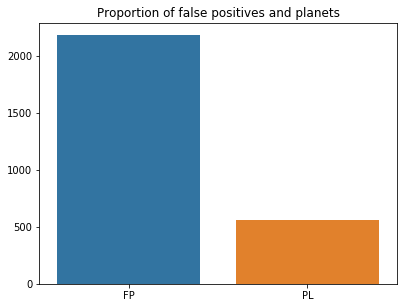

In [2]:
show dis:select n:count i by planet from tces

.p.import[`warnings][`:filterwarnings]`ignore;
sns:.p.import`seaborn
plt:.p.import`matplotlib.pyplot

sns[`:barplot][`FP`PL;exec n from dis][`:set_title]"Proportion of false positives and planets";
plt[`:show][];

## 2. Extract local view

Local view associated to each TCE can be extracted from the light curve of the stars where they were found by using their period, epoch and durarion, therefore, each TCE provides a different view even when some of them are detected in the same star. 

We demonstrate below how to extract the local view from the light curves although, as computing 2734 views takes some time, we only do it for 16 random TCEs in this notebook:

In [3]:
/ Data folder 
/etedir:`:/home/nasafdl/data/ete6

/ Functions to process data
\l ../utils/extractlocal.q

/r:processcurve[etedir]each sample:16?update tce_duration%24 from tces

We can plot them to get a better understanding of what they are like:

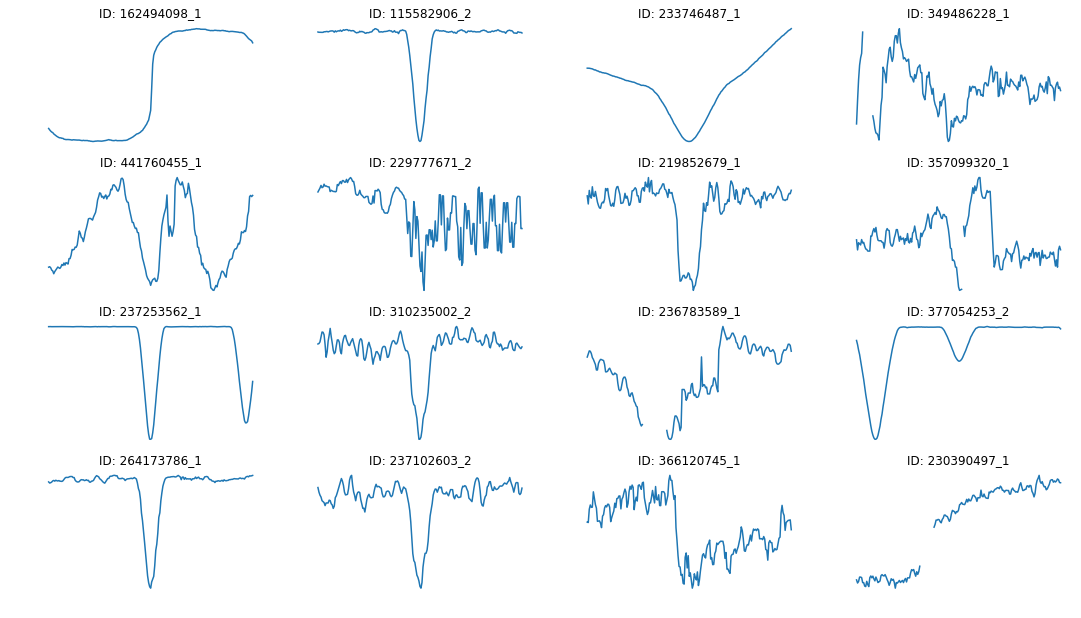

In [4]:
.p.import[`warnings][`:filterwarnings]`ignore;

subplots:plt[`:subplots][4;4]
fig:subplots[@;0]
axarr:subplots[@;1]
fig[`:set_size_inches;18.5;10.5];
{[i]
  j:cross[til 4;til 4]i;
  box:axarr[@;j 0][@;j 1];
  box[`:plot]r[i]`local;
  box[`:axis]`off;
  box[`:set_title]"ID: ",string sample[i]`tceid;
 }each til 16;
plt[`:show][];

Data has been split into training, validation and test sets. For each dataset, local view of each TCE has been computed and saved in csv files before creating this notebook to avoid waiting for all the light curves to be processed. Curves were saved as columns in the files so each column represents the local view of the light curve associated with a TCE and the column name is the TCE identifier. Information associated with each set was also saved in csv files. Thus, we can directly load the data.


### Training data

In [4]:
show 5#trndata:reverse fills reverse fills(2187#"F";(),csv)0:`:../data/trndata.csv
-1"\nThere are 2187 TCES for training\n";

show 5#trnlabels:("SJIIFFFI";(),csv)0:`:../data/trninfo.csv

162494098_1 199667851_1 236777961_1 355926765_1 229780556_1 219872948_1 357686750_1 237278955_2 2..
-------------------------------------------------------------------------------------------------..
-0.5811667  0.02580832  0.146141    -0.1116448  0.1161117   -0.03735102 -0.03774671 -0.0505874  -..
-0.626689   0.00743681  0.1349218   -0.08606082 0.15031     -0.01853559 -0.01369243 -0.0129869  -..
-0.6657348  0.004927457 0.1321083   -0.07210563 0.1347195   -0.02041219 -0.02664474 0.08307631  -..
-0.6968596  0.01590778  0.1447634   -0.068402   0.1295872   -0.03164713 -0.0332648  0.05581162  -..
-0.7136334  0.006220154 0.1433625   -0.03152089 0.1677491   -0.04386153 -0.05386513 0.1784118   -..

There are 2187 TCES for training

tceid       catid     n_planets tce_num tce_period tce_time0bk tce_duration planet
----------------------------------------------------------------------------------
162494098_1 162494098 1         1       0.3419618  1613.04     0.1442783    0     
199667851_1 1996

### Validation data

In [5]:
show 5#valdata:reverse fills reverse fills(274#"F";(),csv)0:`:../data/valdata.csv
-1"\nThere are 274 TCES for validation\n";

show 5#vallabels:("SJIIFFFI";(),csv)0:`:../data/valinfo.csv

232674864_1 9585383_1  233060064_1 198583007_1 229742000_2  233496577_2   229774503_3 39933199_1 ..
-------------------------------------------------------------------------------------------------..
-1          -0.1106756 0.1115924   0.02649501  -0.008915477 0.02045437    0.005554294 -0.2078044 ..
-0.902762   -0.1264137 0.1037193   0.02374142  -0.01080772  -0.006842831  0.005554294 -0.208108  ..
-0.7885983  -0.1264137 0.1193527   0.0232199   0.001334474  -0.01011432   0.005554294 -0.2083795 ..
-0.9303386  -0.1121716 0.0971019   0.0242179   0.01043225   -5.727628e-05 0.005554294 -0.208498  ..
-0.9579151  -0.1306026 0.07569772  0.04175413  0.01258864   -0.009679691  0.005554294 -0.20842   ..

There are 274 TCES for validation

tceid       catid     n_planets tce_num tce_period tce_time0bk tce_duration planet
----------------------------------------------------------------------------------
232674864_1 232674864 2         1       22.11899   1618.277    1.512647     0     
9585383_1   958

### Test data

In [6]:
show 5#tstdata:reverse fills reverse fills(273#"F";(),csv)0:`:../data/tstdata.csv
-1"\nThere are 273 stars for testing\n";

show 5#tstlabels:("SJIIFFFI";(),csv)0:`:../data/tstinfo.csv

236757389_2  309907802_1  410728494_1 287139051_1 72034540_2  88937176_3   119988584_1 390017760_..
-------------------------------------------------------------------------------------------------..
0.003268701  0.01738835   -0.1707733  -0.2363411  -0.01532646 -0.003507993 0.1828209   0.9759511 ..
0.001377123  0.0006785699 0.04111343  -0.1913192  -0.01078818 -0.0170421   0.04984994  0.9759511 ..
0.001377123  -0.01361381  0.07157214  0.2036931   -0.01242174 -0.02170666  -0.01038665 0.8575062 ..
-0.001080581 -0.02129013  0.05191939  0.07662288  -0.0185434  0.1149825    0.1532745   0.1766885 ..
-0.01973576  -0.01740956  0.05191939  0.06120312  -0.01623523 0.1149825    0.1148595   -0.6074898..

There are 273 stars for testing

tceid       catid     n_planets tce_num tce_period tce_time0bk tce_duration planet
----------------------------------------------------------------------------------
236757389_2 236757389 2         2       4.406517   1614.011    0.1258946    0     
309907802_1 30990

## 3. Data preparation

Machine learning algorithms usually require the data to be given as a matrix where each row represents a unique instance. Then, we first need to get the data in this format. Labels also need to be presented as vectors:

In [7]:
/ Training data
xtrain:value flip trndata
ytrain:trnlabels`planet

/ Validation data
xval:value flip valdata
yval:vallabels`planet

/ Test data
xtest:value flip tstdata
ytest:tstlabels`planet

Furthermore, another step is required before building and training a model in this particular case. We mentioned before that the distribution of false positives and real planets is quite unbalanced, which could be an issue when training a model, particularly the neural network since real planets would have low importance in the gradient when updating the weights of the network to minimize the loss function. To deal with this problem, we decide to use oversampling, this is, we will get a random sample of the positive class and add it to the training set. We will do it in such a way that the final proportion of planets vs non planet will be 50%-50%.

In [8]:
/ Initial proportion of planets vs non planets
-1"The initial proportion of planets is ",string[p0:avg ytrain];
/ Final proportion of planets vs non planets
-1"The proportion of planets after oversampling will be ",string p1:0.5;

sample:(nadd:(-) . sum each ytrain=/:(0 1))?xtrain where ytrain

/ Add the sample to the training set
xoversampled:xtrain,sample
yoversampled:ytrain,nadd#1

/ Shuffle data
ind:neg[n]?til n:count yoversampled
finalxtrain:xoversampled ind
finalytrain:yoversampled ind

-1"Size of the final training set is ",string count finalytrain;

The initial proportion of planets is 0.2030178
The proportion of planets after oversampling will be 0.5
Size of the final training set is 3486


## 4. Benchmark model

As mentioned above, our objective is to train a bayesian neural network able to differentiate dips in the light curves caused by planets. However, building complex models is sometimes useless since similar results can be obtained with simpler models. Therefore, it is important to have a benchmark model that allows us to compare results and better interpret results obtained by more complex models.

#### Linear classifier

The simple model chosen to use as benchmark is a linear classifier, which considers a linear combination of the features to make the predictions. The model tries to linearly separate classes and bases its decisions on that. In order to find the weights of the linear combination that better separate classes, the model has to be trained on the training dataset:

In [9]:
sgd:.p.import[`sklearn.linear_model][`:SGDClassifier][]

sgd[`:fit][finalxtrain;finalytrain];

In this case we do not attempt to find the model that provides the best results but to obtain a benchmark model. Thus, we do not optimize its parameters and the validation set as well as the test sets are used to test the performance of the model.

### 4.1 Predictions

#### Validation set

In [10]:
show valpreds:sgd[`:predict;xval]`

1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1..


Accuracy is usually computed to test performance of a model, however, this is not always a good measure of the performance of the model, especially when dealing with unbalanced datasets due to a classifier always predicting the majority class would achieve a high accuracy too. Precision and recall are better choices in these cases since they allow to differentiate between models that prioritize false positives over false negatives and to make a decision about the best model based on the objective of the particuar problem. The confusion matrix is also very useful because results can be better visualized:

Accuracy: 0.8321168
Precision: 0.556962
Recall: 0.8


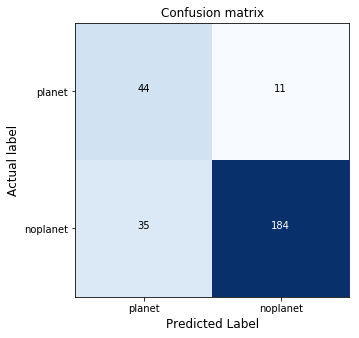

In [11]:
/ Load functions
\l ../utils/functions.q

cm:confmat[1;yval;valpreds]
-1"Accuracy: ",string accuracy[yval;valpreds];
-1"Precision: ",string precision[1;yval;valpreds];
-1"Recall: ",string sensitivity[1;yval;valpreds];

/ Confusion matrix
displayCM[value cm;`planet`noplanet;"Confusion matrix";()]

These metrics show that the linear classifier is able to detect a high proportion of planets (>80%), however, the precision of the model is low, which as mentioned above, we would like to maximize. 

#### Test set

The same results can be obtained using the test set, which will also allow us to compare results afterwards:

0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0..

Accuracy: 0.8241758
Precision: 0.5806452
Recall: 0.6206897


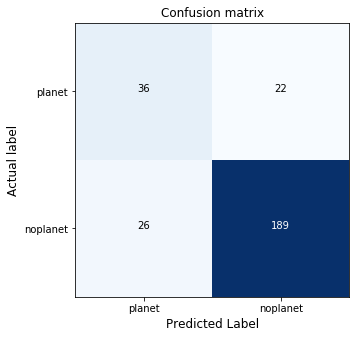

In [12]:
show testpreds:sgd[`:predict;xtest]`

cm:confmat[1;ytest;testpreds]
-1"\nAccuracy: ",string accuracy[ytest;testpreds];
-1"Precision: ",string precision[1;ytest;testpreds];
-1"Recall: ",string sensitivity[1;ytest;testpreds];

/ Confusion matrix
displayCM[value cm;`planet`noplanet;"Confusion matrix";()]

Results are similar to the obtained on the validation set, which means we are far from our requirements. Therefore, a bayesian neural network is built and train to try to improve these results.

## 5. Bayesian Neural Network

### 5.1 Model building

Bayesian Neural Networks require of several parameters that determine their behaviour so we define a dictionary that comprise the values of the parameters to use:

In [13]:
show paramdict:`lr`mxstep`layersize`activation`batchsize`nmontecarlo`trainsize!(0.01;10000;128 128;`relu;512;500;count finalytrain)

lr         | 0.01
mxstep     | 10000
layersize  | 128 128
activation | `relu
batchsize  | 512
nmontecarlo| 500
trainsize  | 3486


Furthermore, we need some extra data preparation; we have to split it into batches. In order to do that, we create two functions:

* `buildtraining`: splits training dataset into batches of specified size and creates an iterator that allows the neural network to train on all the batches when learning.
* `builditerator`: creates an iterator of size 1, which captures the whole set. 

To build these functions we make use of embedPy, which allows to import functions and python libraries to take advantage of the machine learning algorithms they include. Python functions can interact with q data as native q functions so we can use them really easily. 

In [14]:
tf:.p.import`tensorflow
np:.p.import[`numpy]
array:np[`:array]
pylist:.p.import[`builtins]`:list
tuple:.p.import[`builtins]`:tuple

buildtraining:{[x;y;size]
 dataset:tf[`:data.Dataset.from_tensor_slices]tuple(np[`:float32;x]`.;np[`:int32;y]`.);
 batches:dataset[`:repeat][][`:batch]size;
 iterator:batches[`:make_one_shot_iterator][];
 handle:tf[`:placeholder][tf`:string;`shape pykw()];
 feedable:tf[`:data.Iterator.from_string_handle][handle;batches`:output_types;batches`:output_shapes];
 data:feedable[`:get_next][][@;]each 0 1;
 `local`labels`handle`iterator!{x`.}each raze(data;handle;iterator)
 }

builditerator:{[x;y;size]
 dataset:tf[`:data.Dataset.from_tensor_slices]tuple(np[`:float32;x]`.;np[`:int32;y]`.);
 frozen:dataset[`:take][size][`:repeat][][`:batch]size;
 frozen[`:make_one_shot_iterator][]
 }

An iterator with batches of size 512 is created using the training set while validation and test sets are converted to iterators of size 1 so they are represented in the same way as the training set and can be passed to the neural network and obtain predictions.

In [15]:
traindict:buildtraining[finalxtrain;finalytrain;paramdict`batchsize]
iterators:`val`test!{x`.}each builditerator ./:((xval;yval;count yval);(xtest;ytest;count ytest))

Finally, we can pass this data to the python process running in q and load the script that contains the model and the code to train it:

In [16]:
{.p.set[x]get x}each`paramdict`traindict`iterators;

\l ../utils/bnn.p

Step:   0
Train loss: 31.488 Train accuracy: 0.543
Step: 100
Train loss: 19.670 Train accuracy: 0.855
Step: 200
Train loss: 10.579 Train accuracy: 0.864
Step: 300
Train loss: 5.231 Train accuracy: 0.855
Step: 400
Train loss: 2.827 Train accuracy: 0.845
Step: 500
Train loss: 1.844 Train accuracy: 0.839
Step: 600
Train loss: 1.535 Train accuracy: 0.835
Step: 700
Train loss: 1.328 Train accuracy: 0.832
Step: 800
Train loss: 1.410 Train accuracy: 0.829
Step: 900
Train loss: 1.241 Train accuracy: 0.828
Step: 1000
Train loss: 1.308 Train accuracy: 0.827
Step: 1100
Train loss: 1.192 Train accuracy: 0.826
Step: 1200
Train loss: 1.200 Train accuracy: 0.825
Step: 1300
Train loss: 1.195 Train accuracy: 0.824
Step: 1400
Train loss: 1.225 Train accuracy: 0.824
Step: 1500
Train loss: 1.391 Train accuracy: 0.824
Step: 1600
Train loss: 1.484 Train accuracy: 0.823
Step: 1700
Train loss: 1.173 Train accuracy: 0.823
Step: 1800
Train loss: 1.113 Train accuracy: 0.823
Step: 1900
Train loss: 1.214 Train acc

### 5.2  Predictions

We will base our predictions of the stars in the validation and test sets on montecarlo samples of size 500, extracted from the probabilities of each TCE of being a real planet or false positive, provided by the trained bayesian neural network. However, these probabilites do not reproduce a fair distribution of the data since the network was trained on the oversampled dataset so we should first correct these probabilites to show the right distribution of the data.


#### Validation set

In [17]:
p)val_handle = sess.run(iterators['val'].string_handle())
p)probs=[sess.run((labels_distribution.probs),feed_dict={handle:val_handle}) for _ in range(paramdict['nmontecarlo'])]
valprobs:`float$.p.get[`probs]`

corprobs:{[p0;p1;p]
 1%1+(((1%p0)-1)%(1%p1)-1)*(1%p)-1
 }

corvalprobs:{[p0;p1;p;i].[p;(::;::;i);corprobs . $[i=0;(1-p0;1-p1);(p0;p1)]]}[p0;p1]/[valprobs;0 1]

Once we have the corrected probabilities, we compute the mean of the probabilities of each class and predict the instances as the class associated to the maximum mean probability. 

In [18]:
show valpreds:{x?max x}each avg corvalprobs

0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1..


The accuracy of the predictions is tested using different metrics and the confusion matrix:

Accuracy: 0.9343066
Precision: 0.893617
Recall: 0.7636364


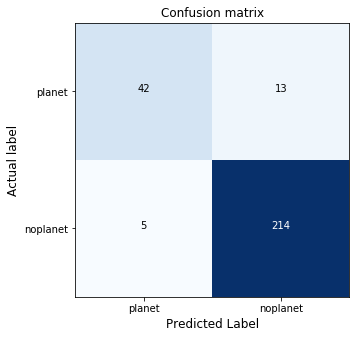

In [19]:
cm:confmat[1;yval;valpreds]
-1"Accuracy: ",string accuracy[yval;valpreds];
-1"Precision: ",string precision[1;yval;valpreds];
-1"Recall: ",string sensitivity[1;yval;valpreds];

/ Confusion matrix
displayCM[value cm;`planet`noplanet;"Confusion matrix";()]

Results show that we have been able to deal with the low proportion of planets and train a model that captures a high proportion of planets (>70%) by using oversampling, furthermore, this has notled to a low sensitivity and the model only identifies 7 false positives as planets. As a consequence, we could say that results are satisfactory, especially compared to the results obtained by the linear classifier.

However, in case we are not happy enough with these results, we can tune the parametes of the model and try to get results that better fit our requirements. Models with different parameters should be tested on the validation set and once the preferred model is chosen, it can be tested on the test dataset.

#### Test set

Let's assume the previously trained model fits our requirements since it gets high accuracy, precision and recall. The performance of the final model should be tested on the test dataset (final model should be trained again using training and validation sets together but we won't train it again to keep the demonstration brief).

To obtain the prediction of the test set we do exactly the same as we did with the validation set before:

In [20]:
p)test_handle = sess.run(iterators['test'].string_handle())
p)probs=[sess.run((labels_distribution.probs),feed_dict={handle:test_handle}) for _ in range(paramdict['nmontecarlo'])]
testprobs:`float$.p.get[`probs]`

cortestprobs:{[p0;p1;p;i].[p;(::;::;i);corprobs . $[i=0;(1-p0;1-p1);(p0;p1)]]}[p0;p1]/[testprobs;0 1]

In [21]:
show testpreds:{x?max x}each avg cortestprobs

0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0..


Accuracy: 0.9120879
Precision: 0.8695652
Recall: 0.6896552


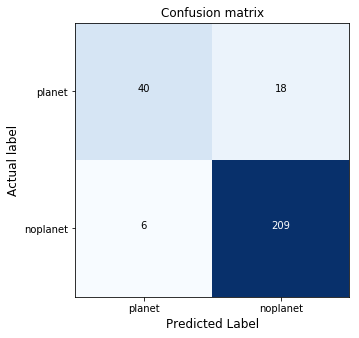

In [22]:
cm:confmat[1;ytest;testpreds]
-1"Accuracy: ",string accuracy[ytest;testpreds];
-1"Precision: ",string precision[1;ytest;testpreds];
-1"Recall: ",string sensitivity[1;ytest;testpreds];

/ Confusion matrix
displayCM[value cm;`planet`noplanet;"Confusion matrix";()]

In the case of the test set, the neural network identifies 37 TCEs as actual planets and 210 as false detections, which leads to 90% accuracy. Besides, even though getting high recall and precision when dealing with unbalanced datasets is usually a complicated taks, we can appreciate that the proposed solution achieves 64% sensitivity and 88% precision, which highly improves the precision score obtained with the benchmark model.

### 5.3 Prediction confidence

An advantage of bayesian neural networks is their capacity to quantify confidence in predictions. They allow to get a distribution of the probabilities of each class and determine if the prediction for a given instance is nearly random or it is confident in it. 

We can check this confidence by plotting the distribution of the montecarlo samples extracted from the probabities of 10 random TCES in the validation set.

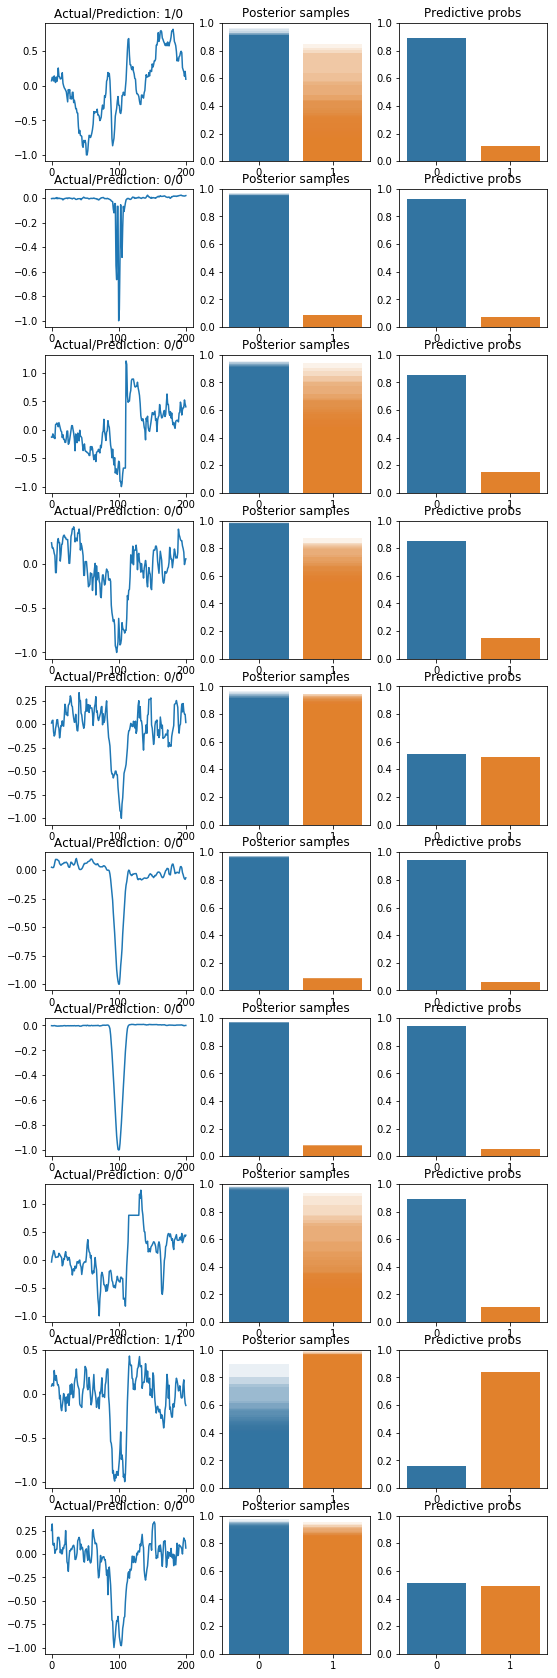

In [23]:
n:10

.p.import[`warnings][`:filterwarnings]`ignore;

sns:.p.import`seaborn
fig:plt[`:figure]`figsize pykw 9,3*n;

{[n;xval;yval;pred;p;i]
 ind:rand count yval;
 
 ax:fig[`:add_subplot][n;3;1+3*i];
 ax[`:plot]xval ind;
 ax[`:set_title]"Actual/Prediction: ",string[yval ind],"/",string pred ind;

 ax:fig[`:add_subplot][n;3;2+3*i];
 {[ax;p;ind;j]
   sns[`:barplot][0 1;p[j;ind];`alpha pykw 0.1;`ax pykw ax];
   ax[`:set_ylim]0 1;
 }[ax;p;ind]each til count p;
 ax[`:set_title]"Posterior samples";

 ax:fig[`:add_subplot][n;3;3+3*i];
 sns[`:barplot][0 1;avg p[;ind;];`ax pykw ax];
 ax[`:set_ylim]0 1;
 ax[`:set_title]"Predictive probs";

 }[n;xval;yval;valpreds;corvalprobs]each til n;

plt[`:show][];

## 6. Visualization

Finally, we can show some curves of different random TCEs and their predictions to see how the neural network classifies them:

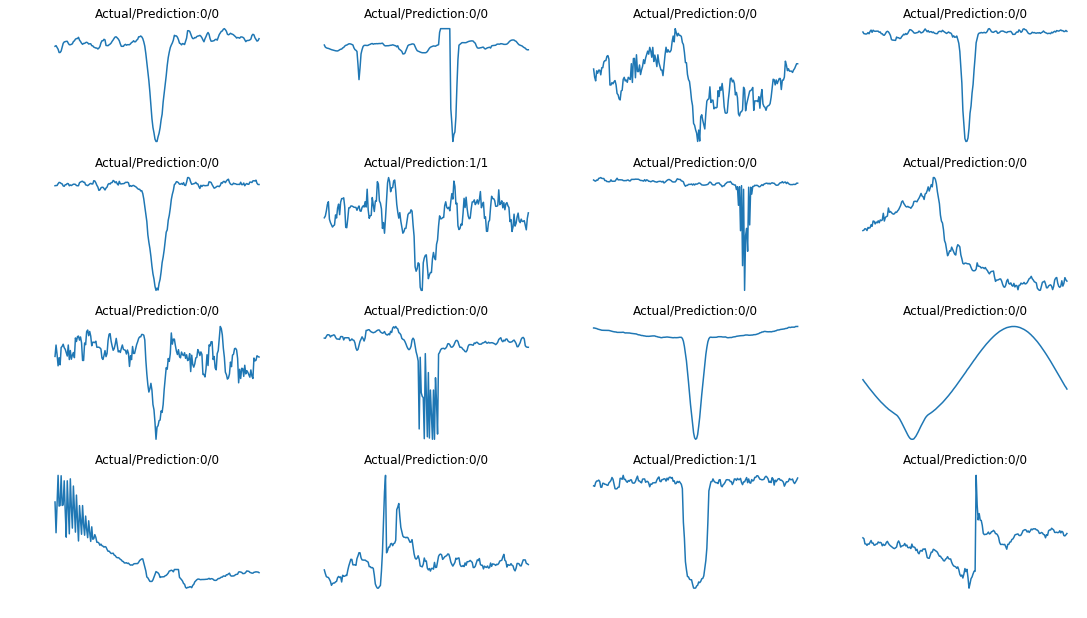

In [24]:
subplots:plt[`:subplots][4;4]
fig:subplots[@;0]
axarr:subplots[@;1]
fig[`:set_size_inches;18.5;10.5];
{[i]
  j:cross[til 4;til 4]i;
  box:axarr[@;j 0][@;j 1];
  box[`:plot]xtest ind:rand count ytest;
  box[`:axis]`off;
  box[`:set_title]"Actual/Prediction:",string[ytest ind],"/",string testpreds ind;
 }each til 16;
plt[`:show][];

We observe in these plots how the dip caused by a planet transit is different from the caused by some other phenomena. Curves produced by real planets have dips that are not as sharp as other dips but they reach the minimum value for a longer period of time. Attending to previous results, the trained neural network seems to be able to capture this difference.